**Inspired by the [first-place solution](https://www.kaggle.com/competitions/image-matching-challenge-2025/discussion/583058) by [@ns6464](https://www.kaggle.com/ns6464), I've put together a demo showcasing how to run MASt3R within Kaggle.**

In [1]:
import sys

In [2]:
class CONFIG:
    # DEBUG Settings
    DRY_RUN = False
    DRY_RUN_MAX_IMAGES = 10

    # Pipeline settings
    NUM_CORES = 2
    MAST3R_MIN_PAIR = 15

In [3]:
!pip install --no-index /kaggle/input/imc2024-packages-lightglue-rerun-kornia/* --no-deps

Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia-0.7.2-py2.py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_moons-0.2.9-py3-none-any.whl
ERROR: kornia_rs-0.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl is not a supported wheel on this platform.


In [4]:
!pip install torch torchvision torchaudio --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [5]:
!pip install faiss-gpu-cu12 --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [6]:
# 离线安装所有依赖（不联网）
!pip install --no-index --find-links=/kaggle/input/mast3r-fix/mast3r-wheels \
    -r /kaggle/input/mast3r-fix/mast3r/requirements.txt \
    -r /kaggle/input/mast3r-fix/mast3r/dust3r/requirements.txt \
    -r /kaggle/input/mast3r-fix/mast3r/dust3r/requirements_optional.txt

Looking in links: /kaggle/input/mast3r-fix/mast3r-wheels


In [7]:
# 加入源码主目录（包含 mast3r, dust3r 等子目录）
sys.path.insert(0, "/kaggle/input/mast3r-fix/mast3r")
sys.path.insert(0, '/kaggle/input/mast3r-fix/mast3r/asmk')
sys.path.insert(0, '/kaggle/input/mast3r-fix/mast3r/dust3r/croco/models/curope')

# Run gradio demo with internet on mode:

> !PYTHONPATH="/kaggle/input/mast3r-fix/mast3r/asmk:$PYTHONPATH" python3 /kaggle/input/mast3r-fix/mast3r/demo.py --weights /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth --share

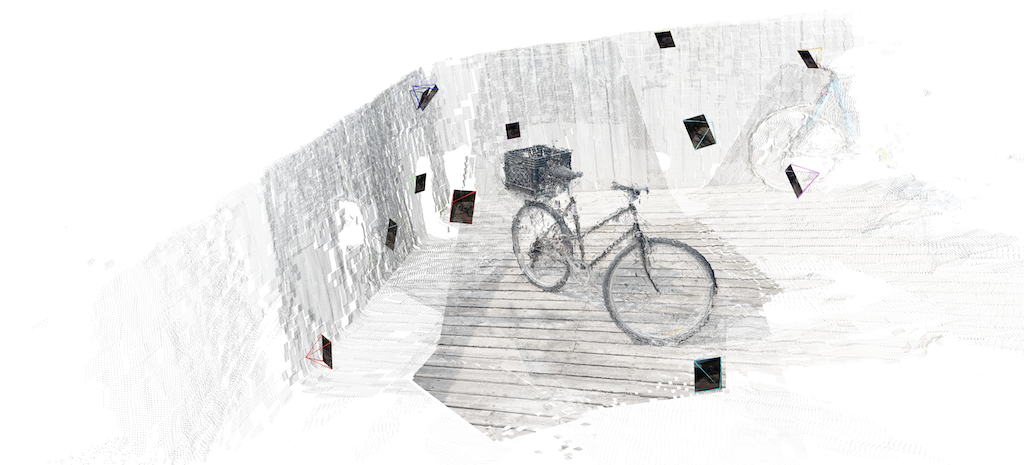

In [8]:
# # %cd /kaggle/working/mast3r
# !PYTHONPATH="/kaggle/input/mast3r-fix/mast3r/asmk:$PYTHONPATH" python3 /kaggle/input/mast3r-fix/mast3r/demo.py --weights /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth --share

In [9]:
import random
import os
import numpy as np
import torch
import dataclasses

def seed_everything(seed: int = 42):
    """Set seed for reproducibility across random, numpy, torch (CPU + CUDA)."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [10]:
import sys
import os
from tqdm import tqdm
from time import time, sleep
import gc
import numpy as np
import h5py
import dataclasses
import pandas as pd
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy
from PIL import Image

import cv2
import torch
import torch.nn.functional as F

import torch
from transformers import AutoImageProcessor, AutoModel


# IMPORTANT Utilities: importing data into colmap and competition metric
import pycolmap
sys.path.append('/kaggle/input/imc25-utils')
from database import *
from h5_to_db import *
import metric

from fastprogress import progress_bar

2025-06-11 20:22:13.866737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749673333.891914     424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749673333.899673     424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

In [12]:
# Configuration
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Automatically use GPU if available
print(f"Using device: {device}")

schedule = 'cosine' # These seem to be unused in the provided snippet, but keep for context
lr = 0.01
niter = 300
local_model_directory = "/kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"

# Now, we manually call `load_model` as suggested by `mast3r/model.py`'s `from_pretrained` logic
from mast3r.model import load_model # Assuming load_model is defined in mast3r/model.py or accessible

print(f"Loading model from local path: {local_model_directory}")
mast3r_model = load_model(local_model_directory, device=device) # Pass device to load_model
print("Model loaded successfully.")

Using device: cuda
Loading model from local path: /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
... loading model from /kaggle/input/mast3r-fix/mast3r/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth


/kaggle/input/mast3r-fix/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>
Model loaded successfully.


>> Loading a list of 2 images
 - adding /kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0003.png with resolution 1024x684 --> 512x336
 - adding /kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0004.png with resolution 576x1024 --> 288x512
 (Found 2 images)


/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


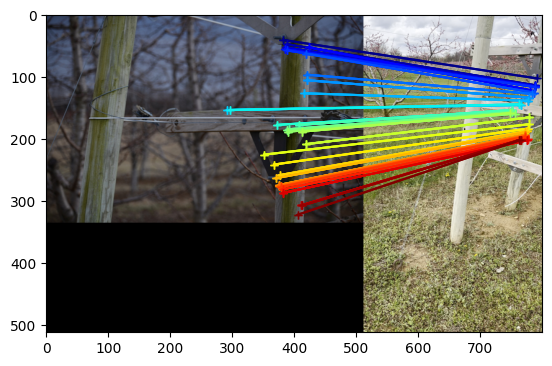

In [13]:

images = load_images(['/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0003.png', 
                      '/kaggle/input/image-matching-challenge-2025/train/amy_gardens/peach_0004.png'], size=512)
output = inference([tuple(images)], mast3r_model, device, batch_size=1, verbose=False)

# at this stage, you have the raw dust3r predictions
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

# find 2D-2D matches between the two images
matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                               device=device, dist='dot', block_size=2**13)

# ignore small border around the edge
H0, W0 = view1['true_shape'][0]
valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
    matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

H1, W1 = view2['true_shape'][0]
valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
    matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

n_viz = 100
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap('jet')
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
pl.show(block=True)

In [14]:
def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs

In [15]:
import kornia as K
import kornia.feature as KF
# --- Helper function for image loading (if not already defined) ---
def load_torch_image(fname, device=torch.device('cpu')):
    img = K.io.load_image(fname, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

In [16]:
# Must Use efficientnet global descriptor to get matching shortlists.
def get_global_desc(fnames, device = torch.device('cpu')):
    processor = AutoImageProcessor.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = AutoModel.from_pretrained('/kaggle/input/dinov2/pytorch/base/1')
    model = model.eval()
    model = model.to(device)
    global_descs_dinov2 = []
    for i, img_fname_full in tqdm(enumerate(fnames),total= len(fnames)):
        key = os.path.splitext(os.path.basename(img_fname_full))[0]
        timg = load_torch_image(img_fname_full)
        with torch.inference_mode():
            inputs = processor(images=timg, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs)
            dino_mac = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=1, p=2)
        global_descs_dinov2.append(dino_mac.detach().cpu())
    global_descs_dinov2 = torch.cat(global_descs_dinov2, dim=0)
    return global_descs_dinov2


def get_img_pairs_exhaustive(img_fnames):
    index_pairs = []
    for i in range(len(img_fnames)):
        for j in range(i+1, len(img_fnames)):
            index_pairs.append((i,j))
    return index_pairs

In [17]:
def get_image_pairs_shortlist_org(fnames,
                              sim_th = 0.6, # should be strict
                              min_pairs = 60,
                              exhaustive_if_less = 20,
                              device=torch.device('cpu')):
    num_imgs = len(fnames)
    if num_imgs <= exhaustive_if_less:
        return get_img_pairs_exhaustive(fnames)
    descs = get_global_desc(fnames, device=device)
    dm = torch.cdist(descs, descs, p=2).detach().cpu().numpy()

    
    mask = dm <= sim_th
    total = 0
    matching_list = []
    ar = np.arange(num_imgs)
    already_there_set = []
    for st_idx in range(num_imgs-1):
        mask_idx = mask[st_idx]
        to_match = ar[mask_idx]
        if len(to_match) < min_pairs:
            to_match = np.argsort(dm[st_idx])[:min_pairs]  
        for idx in to_match:
            if st_idx == idx:
                continue
            if dm[st_idx, idx] < 10000:
                matching_list.append(tuple(sorted((st_idx, idx.item()))))
                total+=1
    matching_list = sorted(list(set(matching_list)))
    return matching_list

In [18]:
def reconstruct_from_db(feature_dir, img_dir):
    result = {}
    local_timings = {'RANSAC': [], 'Reconstruction': []}
    #############################################################
    # regist keypoints from h5 into colmap db
    #############################################################
    database_path = f'{feature_dir}/colmap.db'
    if os.path.isfile(database_path):
        os.remove(database_path)
    gc.collect()
    import_into_colmap(img_dir, feature_dir=feature_dir, database_path=database_path)
    output_path = f'{feature_dir}/colmap_rec'
    os.makedirs(output_path, exist_ok=True)
    print("colmap database")
    #############################################################
    # Calculate fundamental matrix with colmap api
    #############################################################
    t=time()
    # options = pycolmap.SiftMatchingOptions()
    # options.confidence = 0.9999
    # options.max_num_trials = 20000
    # pycolmap.match_exhaustive(database_path, sift_options=options)
    pycolmap.match_exhaustive(database_path)
    # print("matching done!!!!")
    local_timings['RANSAC'].append(time() - t)
    print(f'RANSAC in {local_timings["RANSAC"][-1]:.4f} sec')

    #############################################################
    # Execute bundle adjustmnet with colmap api
    # --> Bundle adjustment Calcs Camera matrix, R and t
    #############################################################
    t=time()
    # By default colmap does not generate a reconstruction if less than 10 images are registered. Lower it to 3.
    mapper_options = pycolmap.IncrementalPipelineOptions()
    # mapper_options.mapper.filter_max_reproj_error	 = 10.0
    mapper_options.min_model_size = 8
    mapper_options.max_num_models = 25
    maps = pycolmap.incremental_mapping(database_path=database_path, image_path=img_dir, 
                                        output_path=output_path, options=mapper_options)
    print(maps)
    for map_index, rec in maps.items():
        result[map_index] = {}
        for img_id, image in rec.images.items():
            result[map_index][image.name] = {
                'R': image.cam_from_world.rotation.matrix().tolist(),
                't': image.cam_from_world.translation.tolist()
            }
    # clear_output(wait=False)
    local_timings['Reconstruction'].append(time() - t)
    print(f'Reconstruction done in {local_timings["Reconstruction"][-1]:.4f} sec')

    #############################################################
    # Extract R,t from maps 
    #############################################################            
    return result, local_timings

In [19]:
# Collect vital info from the dataset

@dataclasses.dataclass
class Prediction:
    image_id: str | None  # A unique identifier for the row -- unused otherwise. Used only on the hidden test set.
    dataset: str
    filename: str
    cluster_index: int | None = None
    rotation: np.ndarray | None = None
    translation: np.ndarray | None = None

# Set is_train=True to run the notebook on the training data.
# Set is_train=False if submitting an entry to the competition (test data is hidden, and different from what you see on the "test" folder).
is_train = True
data_dir = '/kaggle/input/image-matching-challenge-2025'
workdir = '/kaggle/working/result/'
os.makedirs(workdir, exist_ok=True)

if is_train:
    sample_submission_csv = os.path.join(data_dir, 'train_labels.csv')
else:
    sample_submission_csv = os.path.join(data_dir, 'sample_submission.csv')

samples = {}
competition_data = pd.read_csv(sample_submission_csv)
for _, row in competition_data.iterrows():
    # Note: For the test data, the "scene" column has no meaning, and the rotation_matrix and translation_vector columns are random.
    if row.dataset not in samples:
        samples[row.dataset] = []
    samples[row.dataset].append(
        Prediction(
            image_id=None if is_train else row.image_id,
            dataset=row.dataset,
            filename=row.image
        )
    )

for dataset in samples:
    print(f'Dataset "{dataset}" -> num_images={len(samples[dataset])}')

Dataset "imc2023_haiper" -> num_images=54
Dataset "imc2023_heritage" -> num_images=209
Dataset "imc2023_theather_imc2024_church" -> num_images=76
Dataset "imc2024_dioscuri_baalshamin" -> num_images=138
Dataset "imc2024_lizard_pond" -> num_images=214
Dataset "pt_brandenburg_british_buckingham" -> num_images=225
Dataset "pt_piazzasanmarco_grandplace" -> num_images=168
Dataset "pt_sacrecoeur_trevi_tajmahal" -> num_images=225
Dataset "pt_stpeters_stpauls" -> num_images=200
Dataset "amy_gardens" -> num_images=200
Dataset "fbk_vineyard" -> num_images=163
Dataset "ETs" -> num_images=22
Dataset "stairs" -> num_images=51


In [20]:
def match_with_mast3r_and_save(index_pairs, image_list, feature_dir, model, device):
    os.makedirs(feature_dir, exist_ok=True)
    cache = {}
    unique_keypoints = defaultdict(list)
    out_match = defaultdict(dict)

    # Step 1: Load all unique images
    unique_img_paths = sorted(set([image_list[i] for pair in index_pairs for i in pair]))
    img_tensors = load_images(unique_img_paths, size=512)
    img_name_to_tensor = {name: img for name, img in zip(unique_img_paths, img_tensors)}

    # Step 2: Prepare inference in 2-image batches
    names = list(img_name_to_tensor.keys())
    tensors = list(img_name_to_tensor.values())

    if len(tensors) % 2 != 0:
        tensors.append(tensors[-1])
        names.append(names[-1])

    paired_tensors = [(tensors[i], tensors[i + 1]) for i in range(0, len(tensors), 2)]
    paired_names = [(names[i], names[i + 1]) for i in range(0, len(names), 2)]

    outputs = inference(paired_tensors, model, device=device, batch_size=2)

    view1, pred1 = outputs['view1'], outputs['pred1']
    view2, pred2 = outputs['view2'], outputs['pred2']
    
    # 缓存 desc 和 true_shape
    for i, (name1, name2) in enumerate(paired_names):
        if name1 not in cache:
            cache[name1] = {
                'desc': pred1['desc'][i].squeeze(0).detach(),
                'true_shape': view1['true_shape'][i].tolist()
            }
        if name2 not in cache:
            cache[name2] = {
                'desc': pred2['desc'][i].squeeze(0).detach(),
                'true_shape': view2['true_shape'][i].tolist()
            }
    # print("caching done")
    # Step 3: Matching and unified keypoint indexing
    match_buffer = defaultdict(list)
    for idx1, idx2 in tqdm(index_pairs):
        name1, name2 = image_list[idx1], image_list[idx2]
        desc1, desc2 = cache[name1]['desc'], cache[name2]['desc']
        matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8, device=device)
        print(f"get pair for {os.path.basename(name1)}_{os.path.basename(name2)}, {len(matches_im0)}")
        H0, W0 = cache[name1]['true_shape']
        H1, W1 = cache[name2]['true_shape']
        valid0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < W0 - 3) & (matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < H0 - 3)
        valid1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < W1 - 3) & (matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < H1 - 3)
        valid = valid0 & valid1

        matches_im0 = matches_im0[valid]
        matches_im1 = matches_im1[valid]
        if len(matches_im0) < CONFIG.MAST3R_MIN_PAIR:
            continue

        match_buffer[name1].append(matches_im0)
        match_buffer[name2].append(matches_im1)
        out_match[name1][name2] = np.concatenate([matches_im0, matches_im1], axis=1)
    print("filter match")
    # Step 4: unify keypoints with ID and save
    keypoints_unified = {}
    keypoints_id_map = {}
    for name, pts_list in match_buffer.items():
        pts = np.concatenate(pts_list, axis=0)
        unique_pts, inverse = torch.unique(torch.from_numpy(np.round(pts)), dim=0, return_inverse=True)
        keypoints_unified[name] = unique_pts.numpy()
        keypoints_id_map[name] = inverse
    print("uqnified pts")
    # Step 5: remap matches to keypoint ids
    for k1, group in out_match.items():
        for k2, m in group.items():
            ids0 = keypoints_id_map[k1][:len(m)]
            ids1 = keypoints_id_map[k2][:len(m)]
            out_match[k1][k2] = np.stack([ids0.numpy(), ids1.numpy()], axis=1)
    print("uniqfied matches")
    
    # Save
    save_kpts_file = f'{feature_dir}/keypoints.h5'
    save_matches_file = f'{feature_dir}/matches.h5'

    for f in [save_kpts_file, save_matches_file]:
        if os.path.exists(f):
            os.remove(f)

    # In keypoints save:
    with h5py.File(save_kpts_file, 'w') as f_kp:
        for name, pts in keypoints_unified.items():
            if name in f_kp:
                del f_kp[name]
            f_kp.create_dataset(name, data=pts)
    
    # In matches save:
    with h5py.File(save_matches_file, 'w') as f_match:
        for k1, group in out_match.items():
            g = f_match.require_group(k1)
            for k2, m in group.items():
                if k2 in g:
                    del g[k2]
                g.create_dataset(k2, data=m.astype(np.int32))

    print(f"Saved keypoints and matches to {feature_dir}")


In [21]:
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def draw_keypoints_and_matches(images_input, unified_kp_path, remapped_matches_path, feature_dir='visualization_output'):
    output_dir = os.path.join(feature_dir, 'visualization_output')
    os.makedirs(output_dir, exist_ok=True)

    # Load images and determine image_keys for HDF5 lookup
    if isinstance(images_input[0], str):
        loaded_images = [cv2.imread(img_path) for img_path in images_input]
        image_keys = [os.path.basename(img_path) for img_path in images_input]
    else:
        loaded_images = images_input
        # If images_input are already arrays, you need to provide the corresponding keys
        # This part is crucial: image_keys MUST align with the HDF5 keys
        image_keys = image_keys_in_h5 # Use the predefined list for the dummy case

    # Load unified keypoints
    keypoints_data = {}
    with h5py.File(unified_kp_path, 'r') as f_kp:
        for img_name_raw in f_kp.keys():
            img_name = img_name_raw.decode('utf-8') if isinstance(img_name_raw, bytes) else img_name_raw
            keypoints_data[img_name] = f_kp[img_name_raw][()] # Access with raw key if bytes

    # Load remapped matches - CORRECTED LOGIC
    # Store (img1_key, img2_key) directly with matches for robust iteration
    matches_data_pairs = [] # Will store (img1_key, img2_key, matches_array)
    with h5py.File(remapped_matches_path, 'r') as f_matches:
        print("\n--- Loading remapped matches from HDF5 ---")
        for img1_group_key_candidate in tqdm(f_matches.keys(), desc="Loading matches"):
            img1_key = img1_group_key_candidate.decode('utf-8') if isinstance(img1_group_key_candidate, bytes) else img1_group_key_candidate

            img1_group = f_matches[img1_group_key_candidate] # Access with raw key

            if isinstance(img1_group, h5py.Group):
                for img2_dataset_key_candidate in img1_group.keys():
                    img2_key = img2_dataset_key_candidate.decode('utf-8') if isinstance(img2_dataset_key_candidate, bytes) else img2_dataset_key_candidate

                    try:
                        matches_array = img1_group[img2_dataset_key_candidate][()]
                        matches_data_pairs.append((img1_key, img2_key, matches_array))
                    except Exception as e:
                        print(f"Error loading matches for pair ({img1_key}, {img2_key}): {e}")
            else:
                print(f"Warning: Expected '{img1_key}' to be a group, but found {type(img1_group)}. Skipping its contents.")


    # --- Drawing Keypoints ---
    print("\n--- Drawing Keypoints ---")
    for i, img_key in enumerate(image_keys):
        if img_key in keypoints_data:
            img = loaded_images[i].copy()
            kpts = keypoints_data[img_key]

            for kp in kpts:
                x, y = int(kp[0]), int(kp[1])
                cv2.circle(img, (x, y), 3, (0, 255, 0), -1) # Green circle for keypoint

            output_kp_path = os.path.join(output_dir, f"keypoints_{img_key}")
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            cv2.imwrite(output_kp_path, img)
            print(f"Keypoints drawn on {img_key}, saved to {output_kp_path}")
        else:
            print(f"No keypoints found for {img_key} in unified keypoints file.")

    # --- Drawing Matches ---
    print("\n--- Drawing Matches ---")
    # Iterate through the (img1_key, img2_key, matches) tuples directly
    for img_name1, img_name2, matches in matches_data_pairs:
        # We no longer need to split img_pair_key, as we have img_name1 and img_name2 directly

        # Find the actual image objects and their keypoints using image_keys list
        try:
            img1_idx = image_keys.index(img_name1)
            img2_idx = image_keys.index(img_name2)
        except ValueError:
            print(f"Skipping matches for {img_name1}-{img_name2}: One or both image names not found in the provided 'images' list/keys.")
            continue

        img1 = loaded_images[img1_idx].copy()
        img2 = loaded_images[img2_idx].copy()

        kpts1 = keypoints_data.get(img_name1)
        kpts2 = keypoints_data.get(img_name2)

        if kpts1 is None or kpts2 is None:
            print(f"Skipping matches for {img_name1}-{img_name2}: keypoints not found for one or both images in unified keypoints.")
            continue
        if len(matches) == 0:
            print(f"No matches to draw for {img_name1}-{img_name2}.")
            continue

        # Ensure images are 3 channels for drawing lines
        if len(img1.shape) == 2:
            img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        if len(img2.shape) == 2:
            img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

        # Create a concatenated image for drawing matches
        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        max_h = max(h1, h2)
        matched_img = np.zeros((max_h, w1 + w2, 3), dtype=np.uint8)
        matched_img[0:h1, 0:w1] = img1
        matched_img[0:h2, w1:w1+w2] = img2

        num_matches_to_draw = min(len(matches), 200) # Draw up to 200 matches to avoid clutter, adjust as needed

        for i in range(num_matches_to_draw):
            match = matches[i]
            kp1_idx, kp2_idx = int(match[0]), int(match[1])

            # Bounds check for keypoint indices
            if kp1_idx >= len(kpts1) or kp2_idx >= len(kpts2):
                # print(f"Warning: Match index out of bounds for {img_name1}-{img_name2}. Skipping match {kp1_idx}-{kp2_idx}.")
                continue

            pt1 = tuple(map(int, kpts1[kp1_idx][:2]))
            pt2 = tuple(map(int, kpts2[kp2_idx][:2]))

            # Draw circles on the concatenated image
            cv2.circle(matched_img, pt1, 5, (0, 0, 255), 2) # Red circle on img1 side
            cv2.circle(matched_img, (pt2[0] + w1, pt2[1]), 5, (255, 0, 0), 2) # Blue circle on img2 side

            # Draw a line connecting the matched keypoints
            color = tuple(np.random.randint(0, 255, 3).tolist())
            cv2.line(matched_img, pt1, (pt2[0] + w1, pt2[1]), color, 1)

        output_match_path = os.path.join(output_dir, f"matches_{img_name1}_{img_name2}.png")
        cv2.imwrite(output_match_path, matched_img)
        print(f"Matches drawn between {img_name1} and {img_name2}, saved to {output_match_path}")


# Example call (replace with your actual 'images' list)
# If your 'images' are file paths:
# images_file_paths = ['path/to/your/image1.jpg', 'path/to/your/image2.jpg', ...]
# draw_keypoints_and_matches(images_file_paths, unified_kp_path, remapped_matches_path)

# If your 'images' are loaded numpy arrays (as in the dummy example above):
# draw_keypoints_and_matches(images, unified_kp_path, remapped_matches_path)

In [22]:
import os
import gc
import time
import numpy as np
import concurrent.futures
from pathlib import Path

def run_one_dataset(dataset, predictions, data_dir, workdir, is_train, model, device):
    timings = {
        'rotation_detection': [],
        "shortlisting": [],
        "feature_matching": [],
        "RANSAC": [],
        "Reconstruction": [],
    }

    try:
        images_dir = os.path.join(data_dir, 'train' if is_train else 'test', dataset)
        images = [os.path.join(images_dir, p.filename) for p in predictions]

        print(f'Processing dataset "{dataset}": {len(images)} images')
        filename_to_index = {p.filename: idx for idx, p in enumerate(predictions)}
        feature_dir = os.path.join(workdir, 'featureout', dataset)
        os.makedirs(feature_dir, exist_ok=True)

        t = time.time()
        index_pairs = get_image_pairs_shortlist_org(
            images, sim_th=0.2, min_pairs=10,
            exhaustive_if_less=20, device=device)
        timings['shortlisting'].append(time.time() - t)
        print(f'Shortlisting done: {len(index_pairs)} pairs')
        gc.collect()

        t = time.time()
        match_with_mast3r_and_save(index_pairs, images, feature_dir, model, device)
        timings['feature_matching'].append(time.time() - t)
        print(f'MASt3R matching done in {time.time() - t:.2f} sec')
        gc.collect()

        draw_keypoints_and_matches(images, f"{feature_dir}/keypoints.h5", f"{feature_dir}/matches.h5")

        maps, local_timings = reconstruct_from_db(feature_dir, images_dir)
        for k in local_timings:
            timings[k].extend(local_timings[k])

        registered = 0
        for map_index, cur_map in maps.items():
            for image_name, pose in cur_map.items():
                idx = filename_to_index[image_name]
                pred = predictions[idx]
                pred.cluster_index = map_index
                pred.rotation = np.array(pose['R'])
                pred.translation = np.array(pose['t'])
                registered += 1

        mapping_result_str = f"Dataset {dataset} -> Registered {registered} / {len(images)} images with {len(maps)} clusters"
        return mapping_result_str, timings

    except Exception as e:
        print(f"Error in dataset {dataset}: {e}")
        return f"Dataset \"{dataset}\" -> Failed!", timings


def run_mast3r_pipeline(samples, data_dir, workdir, is_train,  model, device):
    max_images = None
    datasets_to_process = ['ETs'] if is_train else list(samples.keys())

    overall_timings = {
        "shortlisting": [],
        "feature_matching": [],
        "RANSAC": [],
        "Reconstruction": [],
    }
    mapping_result_strs = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:  # Run 2 datasets in parallel
        futures = []
        for dataset, predictions in samples.items():
            if datasets_to_process and dataset not in datasets_to_process:
                print(f"Skipping {dataset}")
                continue
            futures.append(executor.submit(run_one_dataset, dataset, predictions, data_dir, workdir, is_train, model, device))

        for future in concurrent.futures.as_completed(futures):
            result_str, timings = future.result()
            mapping_result_strs.append(result_str)
            # for k in timings:
            #     overall_timings[k].extend(timings[k])

    print('\nResults')
    for s in mapping_result_strs:
        print(s)

    # print('\nTimings')
    # for k, v in overall_timings.items():
    #     print(f'{k} -> total={sum(v):.02f} sec.')


In [23]:
# Helpers
array_to_str = lambda array: ';'.join([f"{x:.09f}" for x in array])
none_to_str = lambda n: ';'.join(['nan'] * n)

submission_file = '/kaggle/working/submission.csv'
with open(submission_file, 'w') as f:
    if is_train:
        f.write('dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset, predictions in samples.items():
            for prediction in predictions:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'

                # ✅ `rotation` is a list of lists, flatten it
                if prediction.rotation is None:
                    rotation_str = none_to_str(9)
                else:
                    rotation_flat =  prediction.rotation.flatten()  # flatten 3x3 list -> 9 elems
                    rotation_str = array_to_str(rotation_flat)

                # ✅ `translation` is a flat list
                if prediction.translation is None:
                    translation_str = none_to_str(3)
                else:
                    translation_str = array_to_str(prediction.translation)

                f.write(f'{prediction.dataset},{cluster_name},{prediction.filename},{rotation_str},{translation_str}\n')
    else:
        f.write('image_id,dataset,scene,image,rotation_matrix,translation_vector\n')
        for dataset, predictions in samples.items():
            for prediction in predictions:
                cluster_name = 'outliers' if prediction.cluster_index is None else f'cluster{prediction.cluster_index}'

                if prediction.rotation is None:
                    rotation_str = none_to_str(9)
                else:
                    rotation_flat =  prediction.rotation.flatten()
                    rotation_str = array_to_str(rotation_flat)

                if prediction.translation is None:
                    translation_str = none_to_str(3)
                else:
                    translation_str = array_to_str(prediction.translation)

                f.write(f'{prediction.image_id},{prediction.dataset},{cluster_name},{prediction.filename},{rotation_str},{translation_str}\n')

# Preview the output
!head {submission_file}


dataset,scene,image,rotation_matrix,translation_vector
imc2023_haiper,outliers,fountain_image_116.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_108.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_101.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_082.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_071.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_025.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_000.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_007.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan
imc2023_haiper,outliers,fountain_image_012.png,nan;nan;nan;nan;nan;nan;nan;nan;nan,nan;nan;nan


In [24]:
run_mast3r_pipeline(samples, data_dir, workdir, is_train, mast3r_model, device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Skipping imc2023_haiper
Skipping imc2023_heritage
Skipping imc2023_theather_imc2024_church
Skipping imc2024_dioscuri_baalshamin
Skipping imc2024_lizard_pond
Skipping pt_brandenburg_british_buckingham
Skipping pt_piazzasanmarco_grandplace
Skipping pt_sacrecoeur_trevi_tajmahal
Skipping pt_stpeters_stpauls
Skipping amy_gardens
Skipping fbk_vineyard
Processing dataset "ETs": 22 images
Skipping stairs


100%|██████████| 22/22 [00:01<00:00, 16.90it/s]


Shortlisting done: 126 pairs
>> Loading a list of 22 images
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et001.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et002.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et003.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et004.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et005.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et006.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matching-challenge-2025/train/ETs/another_et_another_et007.png with resolution 360x640 --> 288x512
 - adding /kaggle/input/image-matchin

  0%|          | 0/11 [00:00<?, ?it/s]/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/kaggle/input/mast3r-fix/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
  1%|          | 1/126 [00:00<00:29,  4.23it/s]

get pair for outliers_out_et001.png_et_et007.png, 249


  2%|▏         | 2/126 [00:00<00:28,  4.37it/s]

get pair for outliers_out_et001.png_et_et003.png, 246


  3%|▎         | 4/126 [00:00<00:24,  5.04it/s]

get pair for outliers_out_et001.png_et_et006.png, 269
get pair for outliers_out_et001.png_another_et_another_et006.png, 215


  5%|▍         | 6/126 [00:01<00:22,  5.44it/s]

get pair for outliers_out_et001.png_another_et_another_et002.png, 229
get pair for outliers_out_et001.png_another_et_another_et004.png, 104


  6%|▋         | 8/126 [00:01<00:20,  5.77it/s]

get pair for outliers_out_et001.png_another_et_another_et008.png, 234
get pair for outliers_out_et001.png_another_et_another_et003.png, 240


  7%|▋         | 9/126 [00:01<00:20,  5.71it/s]

get pair for outliers_out_et001.png_another_et_another_et009.png, 203


  8%|▊         | 10/126 [00:02<00:27,  4.22it/s]

get pair for outliers_out_et003.png_outliers_out_et002.png, 100


  9%|▊         | 11/126 [00:02<00:27,  4.18it/s]

get pair for outliers_out_et003.png_et_et006.png, 172


 10%|▉         | 12/126 [00:02<00:29,  3.86it/s]

get pair for outliers_out_et003.png_et_et008.png, 63


 10%|█         | 13/126 [00:02<00:30,  3.76it/s]

get pair for outliers_out_et003.png_et_et005.png, 177


 11%|█         | 14/126 [00:03<00:29,  3.74it/s]

get pair for outliers_out_et003.png_et_et000.png, 152


 12%|█▏        | 15/126 [00:03<00:28,  3.96it/s]

get pair for outliers_out_et003.png_another_et_another_et006.png, 138


 13%|█▎        | 16/126 [00:03<00:26,  4.13it/s]

get pair for outliers_out_et003.png_another_et_another_et007.png, 167


 13%|█▎        | 17/126 [00:03<00:25,  4.29it/s]

get pair for outliers_out_et003.png_another_et_another_et005.png, 132


 14%|█▍        | 18/126 [00:04<00:24,  4.47it/s]

get pair for outliers_out_et003.png_another_et_another_et001.png, 175


 15%|█▌        | 19/126 [00:04<00:24,  4.30it/s]

get pair for outliers_out_et002.png_et_et007.png, 150


 16%|█▌        | 20/126 [00:04<00:25,  4.23it/s]

get pair for outliers_out_et002.png_et_et006.png, 144


 17%|█▋        | 21/126 [00:04<00:27,  3.87it/s]

get pair for outliers_out_et002.png_et_et001.png, 176


 17%|█▋        | 22/126 [00:05<00:33,  3.12it/s]

get pair for outliers_out_et002.png_et_et004.png, 69


 18%|█▊        | 23/126 [00:05<00:34,  2.99it/s]

get pair for outliers_out_et002.png_et_et008.png, 372


 19%|█▉        | 24/126 [00:05<00:32,  3.14it/s]

get pair for outliers_out_et002.png_et_et005.png, 149


 20%|█▉        | 25/126 [00:06<00:31,  3.26it/s]

get pair for outliers_out_et002.png_another_et_another_et007.png, 144


 21%|██        | 26/126 [00:06<00:28,  3.55it/s]

get pair for outliers_out_et002.png_another_et_another_et003.png, 172


 21%|██▏       | 27/126 [00:06<00:30,  3.22it/s]

get pair for et_et007.png_et_et003.png, 1947


 22%|██▏       | 28/126 [00:07<00:27,  3.52it/s]

get pair for et_et007.png_et_et006.png, 2202


 23%|██▎       | 29/126 [00:07<00:29,  3.27it/s]

get pair for et_et007.png_et_et001.png, 2040


 24%|██▍       | 30/126 [00:07<00:29,  3.22it/s]

get pair for et_et007.png_et_et004.png, 1976


 25%|██▍       | 31/126 [00:08<00:29,  3.22it/s]

get pair for et_et007.png_et_et002.png, 2040


 25%|██▌       | 32/126 [00:08<00:29,  3.17it/s]

get pair for et_et007.png_et_et008.png, 269


 26%|██▌       | 33/126 [00:08<00:30,  3.04it/s]

get pair for et_et007.png_et_et005.png, 1891


 27%|██▋       | 34/126 [00:09<00:29,  3.12it/s]

get pair for et_et007.png_et_et000.png, 2106


 28%|██▊       | 35/126 [00:09<00:27,  3.26it/s]

get pair for et_et007.png_another_et_another_et002.png, 1986


 29%|██▊       | 36/126 [00:09<00:27,  3.24it/s]

get pair for et_et007.png_another_et_another_et010.png, 1915


 29%|██▉       | 37/126 [00:09<00:27,  3.29it/s]

get pair for et_et007.png_another_et_another_et004.png, 1965


 30%|███       | 38/126 [00:10<00:27,  3.25it/s]

get pair for et_et007.png_another_et_another_et008.png, 1997


 31%|███       | 39/126 [00:10<00:25,  3.47it/s]

get pair for et_et007.png_another_et_another_et003.png, 2073


 32%|███▏      | 40/126 [00:10<00:25,  3.38it/s]

get pair for et_et003.png_et_et006.png, 2051


 33%|███▎      | 41/126 [00:11<00:26,  3.17it/s]

get pair for et_et003.png_et_et001.png, 2036


 33%|███▎      | 42/126 [00:11<00:27,  3.00it/s]

get pair for et_et003.png_et_et004.png, 1901


 34%|███▍      | 43/126 [00:11<00:25,  3.23it/s]

get pair for et_et003.png_et_et002.png, 2198


 35%|███▍      | 44/126 [00:12<00:26,  3.14it/s]

get pair for et_et003.png_et_et008.png, 268


 36%|███▌      | 45/126 [00:12<00:26,  3.00it/s]

get pair for et_et003.png_et_et005.png, 1806


 37%|███▋      | 46/126 [00:12<00:26,  3.04it/s]

get pair for et_et003.png_et_et000.png, 2045


 37%|███▋      | 47/126 [00:13<00:26,  3.03it/s]

get pair for et_et003.png_another_et_another_et006.png, 1917


 38%|███▊      | 48/126 [00:13<00:24,  3.14it/s]

get pair for et_et003.png_another_et_another_et002.png, 1911


 39%|███▉      | 49/126 [00:13<00:24,  3.13it/s]

get pair for et_et003.png_another_et_another_et010.png, 2063


 40%|███▉      | 50/126 [00:14<00:24,  3.07it/s]

get pair for et_et003.png_another_et_another_et004.png, 1812


 40%|████      | 51/126 [00:14<00:24,  3.08it/s]

get pair for et_et003.png_another_et_another_et008.png, 1989


 41%|████▏     | 52/126 [00:14<00:22,  3.30it/s]

get pair for et_et003.png_another_et_another_et003.png, 2006


 42%|████▏     | 53/126 [00:14<00:21,  3.36it/s]

get pair for et_et006.png_et_et001.png, 2154


 43%|████▎     | 54/126 [00:15<00:22,  3.19it/s]

get pair for et_et006.png_et_et004.png, 1925


 44%|████▎     | 55/126 [00:15<00:22,  3.19it/s]

get pair for et_et006.png_et_et002.png, 2019


 44%|████▍     | 56/126 [00:15<00:22,  3.13it/s]

get pair for et_et006.png_et_et008.png, 238


 45%|████▌     | 57/126 [00:16<00:22,  3.08it/s]

get pair for et_et006.png_et_et005.png, 2086


 46%|████▌     | 58/126 [00:16<00:22,  3.02it/s]

get pair for et_et006.png_et_et000.png, 2097


 47%|████▋     | 59/126 [00:16<00:20,  3.22it/s]

get pair for et_et006.png_another_et_another_et006.png, 2084


 48%|████▊     | 60/126 [00:17<00:19,  3.45it/s]

get pair for et_et006.png_another_et_another_et002.png, 2177


 48%|████▊     | 61/126 [00:17<00:18,  3.54it/s]

get pair for et_et006.png_another_et_another_et004.png, 2199


 49%|████▉     | 62/126 [00:17<00:18,  3.47it/s]

get pair for et_et006.png_another_et_another_et003.png, 2071


 50%|█████     | 63/126 [00:18<00:19,  3.24it/s]

get pair for et_et001.png_et_et004.png, 2059


 51%|█████     | 64/126 [00:18<00:19,  3.21it/s]

get pair for et_et001.png_et_et002.png, 2190


 52%|█████▏    | 65/126 [00:18<00:19,  3.08it/s]

get pair for et_et001.png_et_et008.png, 304


 52%|█████▏    | 66/126 [00:19<00:20,  2.93it/s]

get pair for et_et001.png_et_et005.png, 1958


 53%|█████▎    | 67/126 [00:19<00:18,  3.14it/s]

get pair for et_et001.png_et_et000.png, 2323


 54%|█████▍    | 68/126 [00:19<00:18,  3.13it/s]

get pair for et_et001.png_another_et_another_et006.png, 2051


 55%|█████▍    | 69/126 [00:20<00:19,  2.97it/s]

get pair for et_et004.png_et_et002.png, 1595


 56%|█████▌    | 70/126 [00:20<00:20,  2.75it/s]

get pair for et_et004.png_et_et008.png, 138


 56%|█████▋    | 71/126 [00:20<00:19,  2.89it/s]

get pair for et_et004.png_et_et005.png, 1697


 57%|█████▋    | 72/126 [00:21<00:18,  2.85it/s]

get pair for et_et004.png_et_et000.png, 1375


 58%|█████▊    | 73/126 [00:21<00:17,  2.97it/s]

get pair for et_et004.png_another_et_another_et010.png, 1606


 59%|█████▊    | 74/126 [00:21<00:16,  3.08it/s]

get pair for et_et004.png_another_et_another_et008.png, 1555


 60%|█████▉    | 75/126 [00:22<00:18,  2.74it/s]

get pair for et_et002.png_et_et008.png, 136


 60%|██████    | 76/126 [00:22<00:17,  2.81it/s]

get pair for et_et002.png_et_et005.png, 1667


 61%|██████    | 77/126 [00:22<00:17,  2.74it/s]

get pair for et_et002.png_et_et000.png, 1618


 62%|██████▏   | 78/126 [00:23<00:16,  2.84it/s]

get pair for et_et002.png_another_et_another_et001.png, 1645


 63%|██████▎   | 79/126 [00:23<00:15,  2.96it/s]

get pair for et_et008.png_et_et005.png, 193


 63%|██████▎   | 80/126 [00:23<00:15,  3.01it/s]

get pair for et_et008.png_et_et000.png, 296


 64%|██████▍   | 81/126 [00:24<00:13,  3.28it/s]

get pair for et_et008.png_another_et_another_et008.png, 251


 65%|██████▌   | 82/126 [00:24<00:13,  3.20it/s]

get pair for et_et008.png_another_et_another_et009.png, 163


 66%|██████▌   | 83/126 [00:24<00:13,  3.16it/s]

get pair for et_et005.png_et_et000.png, 1772


 67%|██████▋   | 84/126 [00:25<00:13,  3.05it/s]

get pair for et_et005.png_another_et_another_et006.png, 1621


 67%|██████▋   | 85/126 [00:25<00:12,  3.21it/s]

get pair for et_et000.png_another_et_another_et006.png, 2277


 68%|██████▊   | 86/126 [00:25<00:12,  3.29it/s]

get pair for et_et000.png_another_et_another_et010.png, 2308


 69%|██████▉   | 87/126 [00:25<00:11,  3.29it/s]

get pair for et_et000.png_another_et_another_et005.png, 2225


 71%|███████   | 89/126 [00:26<00:09,  3.75it/s]

get pair for et_et000.png_another_et_another_et001.png, 2252
get pair for another_et_another_et006.png_another_et_another_et002.png, 1444


 71%|███████▏  | 90/126 [00:26<00:09,  3.94it/s]

get pair for another_et_another_et006.png_another_et_another_et010.png, 1555


 73%|███████▎  | 92/126 [00:27<00:07,  4.43it/s]

get pair for another_et_another_et006.png_another_et_another_et004.png, 1391
get pair for another_et_another_et006.png_another_et_another_et007.png, 1550


 75%|███████▍  | 94/126 [00:27<00:06,  4.59it/s]

get pair for another_et_another_et006.png_another_et_another_et008.png, 1452
get pair for another_et_another_et006.png_another_et_another_et003.png, 1519


 76%|███████▌  | 96/126 [00:27<00:05,  5.11it/s]

get pair for another_et_another_et006.png_another_et_another_et005.png, 1605
get pair for another_et_another_et006.png_another_et_another_et001.png, 1574


 77%|███████▋  | 97/126 [00:28<00:05,  5.19it/s]

get pair for another_et_another_et006.png_another_et_another_et009.png, 1524


 79%|███████▊  | 99/126 [00:28<00:05,  5.21it/s]

get pair for another_et_another_et002.png_another_et_another_et010.png, 2090
get pair for another_et_another_et002.png_another_et_another_et004.png, 2103


 80%|████████  | 101/126 [00:28<00:04,  5.37it/s]

get pair for another_et_another_et002.png_another_et_another_et007.png, 2180
get pair for another_et_another_et002.png_another_et_another_et008.png, 2142


 82%|████████▏ | 103/126 [00:29<00:04,  5.41it/s]

get pair for another_et_another_et002.png_another_et_another_et003.png, 2143
get pair for another_et_another_et002.png_another_et_another_et005.png, 2164


 83%|████████▎ | 105/126 [00:29<00:03,  5.79it/s]

get pair for another_et_another_et002.png_another_et_another_et001.png, 2288
get pair for another_et_another_et002.png_another_et_another_et009.png, 2145


 84%|████████▍ | 106/126 [00:29<00:03,  5.66it/s]

get pair for another_et_another_et010.png_another_et_another_et007.png, 1657


 86%|████████▌ | 108/126 [00:30<00:03,  5.28it/s]

get pair for another_et_another_et010.png_another_et_another_et008.png, 1579
get pair for another_et_another_et010.png_another_et_another_et009.png, 1774


 87%|████████▋ | 109/126 [00:30<00:03,  5.41it/s]

get pair for another_et_another_et004.png_another_et_another_et007.png, 1797


 88%|████████▊ | 111/126 [00:30<00:02,  5.52it/s]

get pair for another_et_another_et004.png_another_et_another_et008.png, 1649
get pair for another_et_another_et004.png_another_et_another_et003.png, 1891


 90%|████████▉ | 113/126 [00:30<00:02,  5.59it/s]

get pair for another_et_another_et004.png_another_et_another_et005.png, 1746
get pair for another_et_another_et004.png_another_et_another_et001.png, 1809


 90%|█████████ | 114/126 [00:31<00:02,  5.73it/s]

get pair for another_et_another_et007.png_another_et_another_et008.png, 1806


 91%|█████████▏| 115/126 [00:31<00:02,  5.36it/s]

get pair for another_et_another_et007.png_another_et_another_et003.png, 1554


 93%|█████████▎| 117/126 [00:31<00:01,  5.11it/s]

get pair for another_et_another_et007.png_another_et_another_et005.png, 1582
get pair for another_et_another_et007.png_another_et_another_et001.png, 1586


 94%|█████████▍| 119/126 [00:32<00:01,  5.08it/s]

get pair for another_et_another_et007.png_another_et_another_et009.png, 1623
get pair for another_et_another_et008.png_another_et_another_et003.png, 1668


 96%|█████████▌| 121/126 [00:32<00:00,  5.39it/s]

get pair for another_et_another_et008.png_another_et_another_et005.png, 1688
get pair for another_et_another_et008.png_another_et_another_et001.png, 1726


 97%|█████████▋| 122/126 [00:32<00:00,  5.36it/s]

get pair for another_et_another_et008.png_another_et_another_et009.png, 1666


 98%|█████████▊| 124/126 [00:33<00:00,  5.16it/s]

get pair for another_et_another_et003.png_another_et_another_et005.png, 1582
get pair for another_et_another_et005.png_another_et_another_et001.png, 1762


 99%|█████████▉| 125/126 [00:33<00:00,  4.98it/s]

get pair for another_et_another_et005.png_another_et_another_et009.png, 1882


100%|██████████| 126/126 [00:33<00:00,  3.76it/s]

get pair for another_et_another_et001.png_another_et_another_et009.png, 1440
filter match


uqnified pts
uniqfied matches
Error in dataset ETs: Incompatible object (Dataset) already exists

Results
Dataset "ETs" -> Failed!


In [25]:
# Definitely Compute results if running on the training set.
# Do not do this when submitting a notebook for scoring. All you have to do is save your submission to /kaggle/working/submission.csv.

if is_train:
    t = time()
    final_score, dataset_scores = metric.score(
        gt_csv='/kaggle/input/image-matching-challenge-2025/train_labels.csv',
        user_csv=submission_file,
        thresholds_csv='/kaggle/input/image-matching-challenge-2025/train_thresholds.csv',
        mask_csv=None if is_train else os.path.join(data_dir, 'mask.csv'),
        inl_cf=0,
        strict_cf=-1,
        verbose=True,
    )
    print(f'Computed metric in: {time() - t:.02f} sec.')

TypeError: 'module' object is not callable